In [1]:
# -*- coding: utf-8 -*-
'''
Jack's Car Rental Problem

Created on Oct.08.2024
'''

import numpy as np
from scipy.stats import poisson
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Global parameters
# Capacity and cost
CAPACITY_STORE_CARS = 20
CAPACITY_MOVE_CARS = 5
RENTAL_INCOME = 10
MOVE_COST = 2

# Discount rate
DISCOUNT_RATE = 0.9

# Threshold of value covergence
THRESHOLD_VALUE = 0.3

# Poisson parameters
K_CUTOFF = 10 # Truncating
# Site 1
RENTAL_CARS_MU_S1 = 3
RETURN_CARS_MU_S1 = 3
# Site 2
RENTAL_CARS_MU_S2 = 4
RETURN_CARS_MU_S2 = 2

# Visualizing policy/value iterations
plt.rcParams['font.family'] = 'Helvetica'

In [96]:
## JackCar class definition
class JackCar:
    def __init__(self):
        # Rental and return probability
        self.ren_prob = np.nan
        self.ret_prob = np.nan
        # Basic pramaters
        self.actions = np.arange(-1*CAPACITY_MOVE_CARS, CAPACITY_MOVE_CARS+1)
        self.value_table = np.zeros((CAPACITY_STORE_CARS+1, CAPACITY_STORE_CARS+1))
        self.q_table = np.zeros((CAPACITY_STORE_CARS+1, CAPACITY_STORE_CARS+1, self.actions.size))
        self.policy = np.zeros((CAPACITY_STORE_CARS+1, CAPACITY_STORE_CARS+1), dtype='int32')
        # State index
        idx1,idx2 = np.meshgrid(np.arange(CAPACITY_STORE_CARS+1), np.arange(CAPACITY_STORE_CARS+1))
        self.state_index = np.vstack([idx1.ravel(), idx2.ravel()]).T
        # Logging iterations
        self.value_iter = []
        self.policy_iter = []
        self.value_iter.append(self.value_table)
        self.policy_iter.append(self.policy)
        self.const_return = True
    
        
    def GenProb(self):
        # Generating rental and return Poisson probability matrix
        ren_prob_s1 = poisson.pmf(np.arange(K_CUTOFF), RENTAL_CARS_MU_S1)
        ret_prob_s1 = poisson.pmf(np.arange(K_CUTOFF), RETURN_CARS_MU_S1)
        
        ren_prob_s2 = poisson.pmf(np.arange(K_CUTOFF), RENTAL_CARS_MU_S2)
        ret_prob_s2 = poisson.pmf(np.arange(K_CUTOFF), RETURN_CARS_MU_S2)
        
        # Rental probability
        ren_prob_s1, ren_prob_s2 = np.meshgrid(ren_prob_s1, ren_prob_s2)
        self.ren_prob = np.multiply(ren_prob_s1, ren_prob_s2)
        # Return probability
        ret_prob_s1, ret_prob_s2 = np.meshgrid(ret_prob_s1, ret_prob_s2)
        self.ret_prob = np.multiply(ret_prob_s1, ret_prob_s2)
    
    def GetValue(self, state, action):
        reward = 0
        # Cost of moving cars  
        reward -= abs(action) * MOVE_COST
        # Number of cars in two sites
        num_cars_s1 = int(min(state[0] - action, CAPACITY_STORE_CARS))
        num_cars_s2= int(min(state[1] + action, CAPACITY_STORE_CARS))
        # Renting cars for profit
        num_s1, num_s2 = np.meshgrid(np.arange(K_CUTOFF), np.arange(K_CUTOFF))
        num_rent = np.vstack([num_s1.ravel(), num_s2.ravel()]).T
        num_rent.resize((K_CUTOFF, K_CUTOFF, 2))
        num_rent[num_rent[:,:,0] > num_cars_s1, 0] = num_cars_s1
        num_rent[num_rent[:,:,1] > num_cars_s2, 1] = num_cars_s2
        # Rental reward
        reward_rent = np.sum(num_rent, axis=2) * RENTAL_INCOME
        # Left cars
        num_store = [num_cars_s1, num_cars_s2] - num_rent
        if self.const_return:
            # Number of returned cars is simplified as constant 
            num_store += [RETURN_CARS_MU_S1, RETURN_CARS_MU_S2]
            num_store[num_store > CAPACITY_STORE_CARS] = CAPACITY_STORE_CARS
            values = self.value_table[num_store[:,:,0], num_store[:,:,1]]
            reward += np.sum(self.ren_prob * (reward_rent + DISCOUNT_RATE * values))
        else:
            # Poisson-distributed number of returned cars 
            for (num_rs1, num_rs2) in itertools.product(range(0, K_CUTOFF), range(0, K_CUTOFF)):
                num_store += [num_rs1, num_rs2]
                num_store[num_store > CAPACITY_STORE_CARS] = CAPACITY_STORE_CARS
                values = self.value_table[num_store[:,:,0], num_store[:,:,1]]
                # reward
                reward += np.sum(self.ren_prob * self.ret_prob[num_rs1, num_rs2] \
                                                * (reward_rent + DISCOUNT_RATE * values))

        return reward
        
    
    def PolicyEvaluation(self):
        # Update value table
        sum_value = float(np.sum(self.value_table))
        new_state_value = np.zeros((CAPACITY_STORE_CARS + 1, CAPACITY_STORE_CARS + 1))
        for i, j in self.state_index:
            a = self.policy[i,j]
            new_state_value[i,j] = self.GetValue([i,j], a)
        self.value_table = new_state_value
        value_delta = abs(np.sum(self.value_table) - sum_value)
        return value_delta
    
    
    def PolicyImporve(self):
        # Update policy table
        new_policy = np.zeros((CAPACITY_STORE_CARS + 1, CAPACITY_STORE_CARS + 1))
        actions = self.actions
        for i, j in self.state_index:
            new_action = []
            # Policy update using optimal action (max q)
            for a in actions:
                if (a >= 0 and a <= i) or (a < 0 and abs(a) <= j):
                    q = self.GetValue([i,j], a)
                    new_action.append(q)
                else:
                    new_action.append(-float('inf'))
            optimal_action = np.argmax(new_action)    
            new_policy[i, j] = actions[optimal_action]      
        policy_alter = np.sum(new_policy != self.policy) != 0
        self.policy = new_policy
        return policy_alter
    
    
    def ValueIteration(self):
        policy_alter = True
        value_delta = 1
        num_iter = 1
        while value_delta > THRESHOLD_VALUE:
            value_delta = self.PolicyEvaluation()
            policy_alter = self.PolicyImporve() 
            # Recording iterations
            self.value_iter.append(self.value_table)
            if policy_alter:
                self.policy_iter.append(self.policy)
            if num_iter == 1 or num_iter % 10 == 0:
                print(f'Iteration: {num_iter}, δ of value: {value_delta}')
            num_iter += 1
    
    def PolicyIteration(self):
        policy_alter = True
        num_iter = 1
        while policy_alter:
            value_delta = self.PolicyEvaluation()
            while value_delta > THRESHOLD_VALUE:
                value_delta = self.PolicyEvaluation()
                self.value_iter.append(self.value_table)
                if num_iter == 1 or num_iter % 10 == 0:
                    print(f'Iteration: {num_iter}, δ of value: {value_delta}')
                num_iter += 1
            policy_alter = self.PolicyImporve()
            self.policy_iter.append(self.policy)

    # Plot functions        
    def PlotHeatmap(self, mx1, mx2, title_mx1, title_mx2):
        sns.set_theme(font_scale=1.2, )
        fig, axs = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,5))
        for ix, prob in enumerate([mx1, mx2]):
            sns.heatmap(prob, square=True, cmap='viridis', ax=axs[ix], cbar_kws={'shrink':0.75})
            axs[ix].set_xlabel('Number of cars in first site')
            axs[ix].set_ylabel('Number of cars in second site')
        axs[0].set_title(title_mx1)
        axs[1].set_title(title_mx2)
        plt.tight_layout() 
        plt.show()


    def PLotRenRetProb(self):
        self.PlotHeatmap(self.ren_prob, self.ret_prob, 'Rental probability', 'Return probability')
    
            
def PlotIter(data, list_idx, title, figsize=(30,8), y=0.78, shrink=0.52):
    sns.set_theme(font_scale=1.3)
    fig, axs = plt.subplots(1, len(list_idx), sharex='col', sharey='row', figsize=figsize)
    for ax_ix, ix in enumerate(list_idx):
        if ix >= len(data):
            break
        sns.heatmap(data[ix], square=True, cmap='coolwarm', ax=axs[ax_ix], cbar_kws={'shrink':shrink})
        axs[ax_ix].set_xlabel('Number of cars in first site')
        axs[ax_ix].set_ylabel('Number of cars in second site')
        axs[ax_ix].set_yticks(axs[ax_ix].get_yticks()[::2]) 
        axs[ax_ix].set_title(f'{title} (iteration {ix})')
    fig.suptitle(f'Iteration of {title}', 
                 y=y, fontsize=30, fontweight='bold')
    plt.tight_layout()
    plt.show()

Generating Poisson-distributed rental and return probability matrices


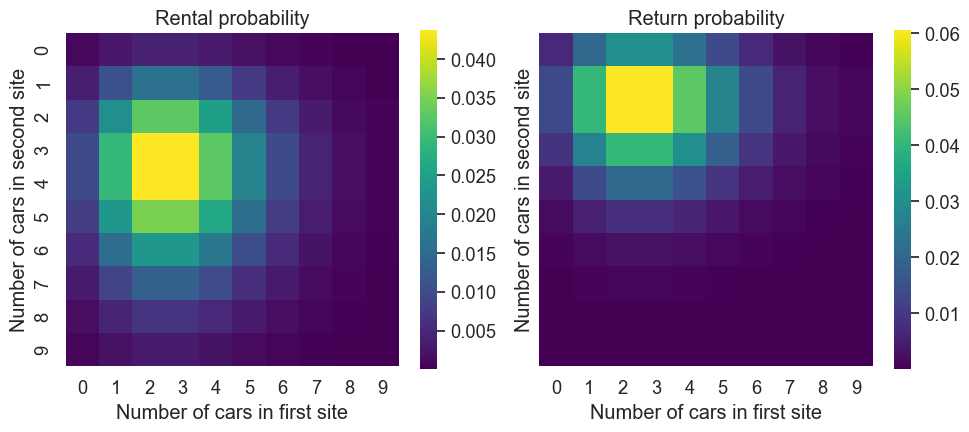

Value iteration starts:
Iteration: 1, δ of value: 26354.47909420741
Iteration: 10, δ of value: 8460.610098540754
Iteration: 20, δ of value: 2457.600718161848
Iteration: 30, δ of value: 773.4932383150444
Iteration: 40, δ of value: 245.69578710506903
Iteration: 50, δ of value: 78.08366145624314
Iteration: 60, δ of value: 24.816009243688313
Iteration: 70, δ of value: 7.886858793412102
Iteration: 80, δ of value: 2.506549011275638
Iteration: 90, δ of value: 0.7966147380939219


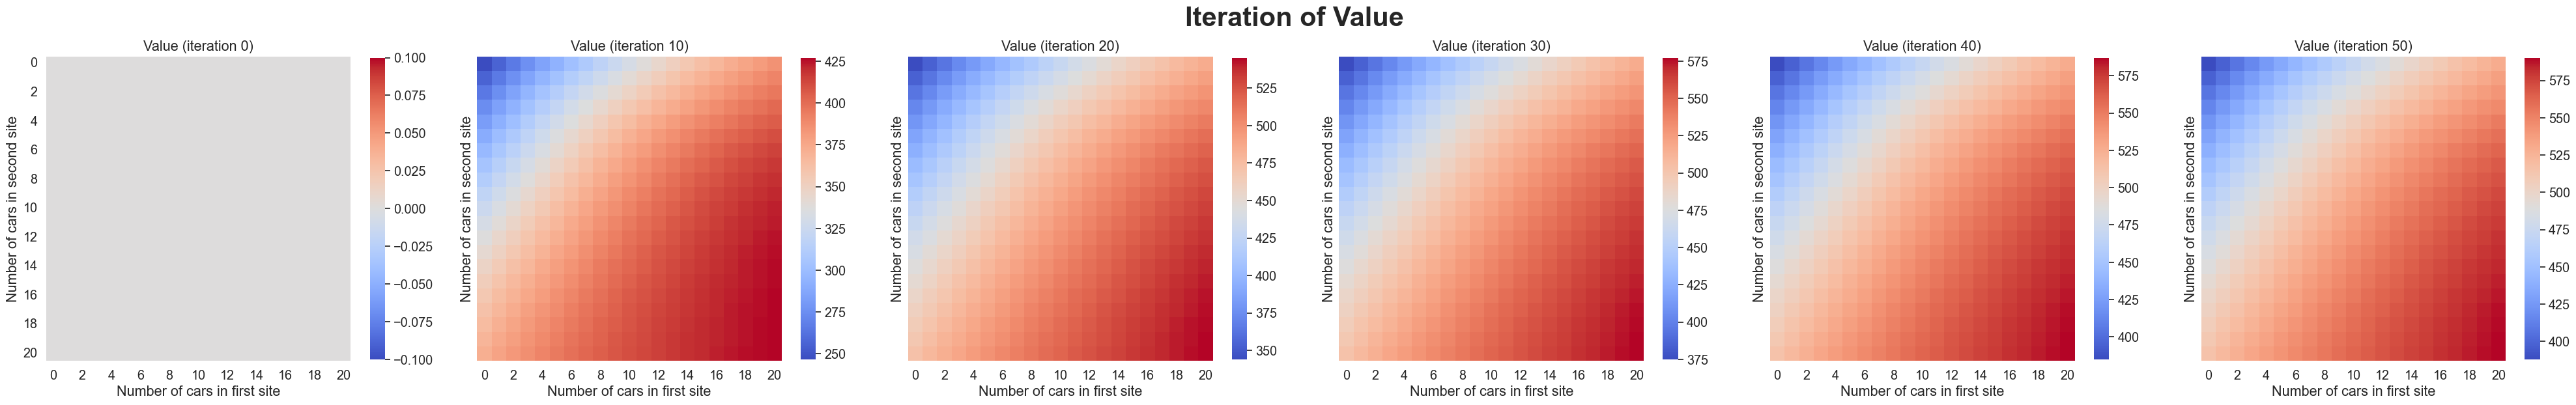

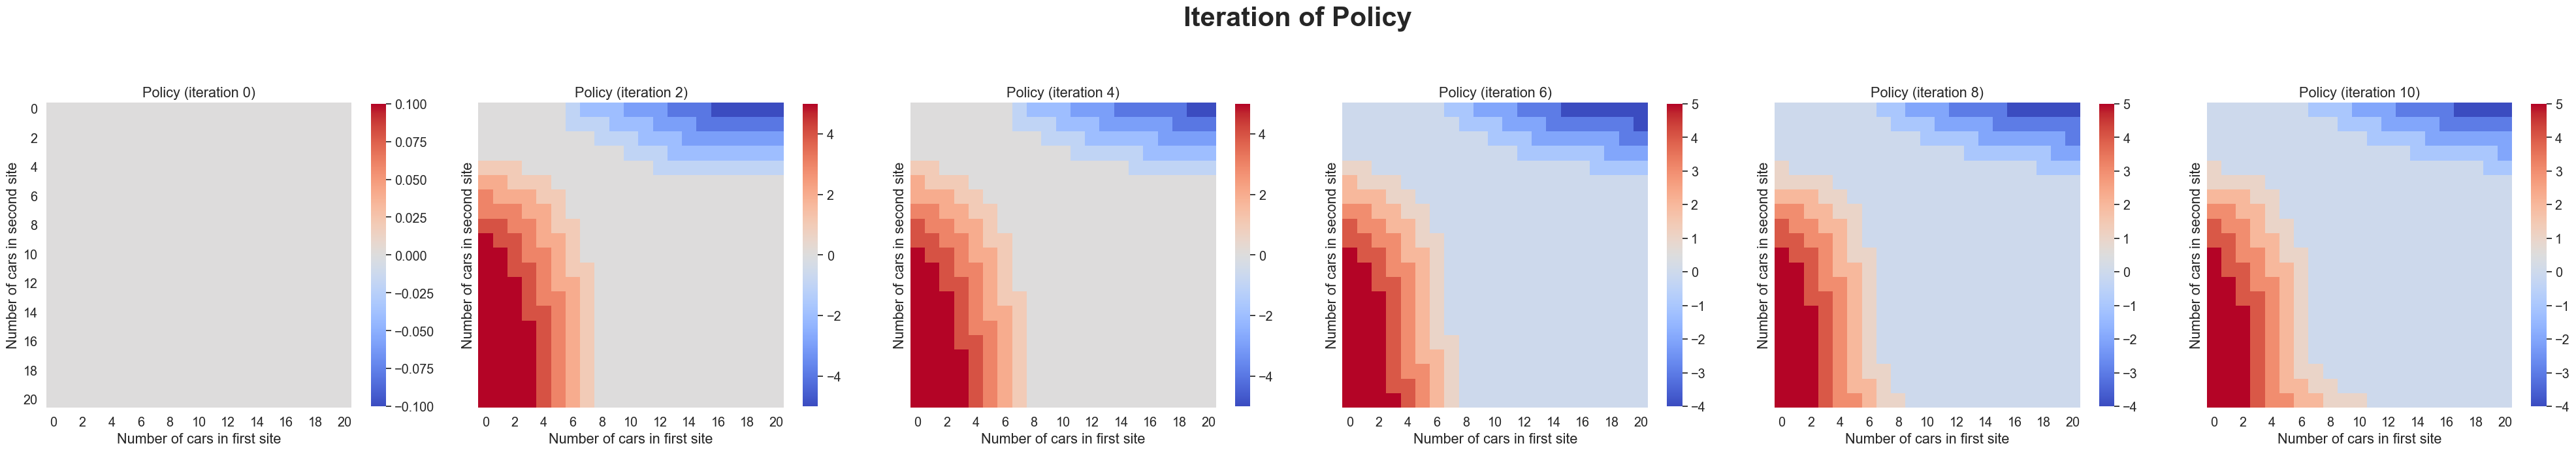

In [87]:
## Value iteration
jack_value = JackCar()
# Return probability is simplified as λ of Poisson distribution (for time consuming)
# Poisson-distributed result is listed below
jack_value.const_return = True
# Generating rental and return probability matrices
jack_value.GenProb()
print('Generating Poisson-distributed rental and return probability matrices')
jack_value.PLotRenRetProb()

# Iteration
print('Value iteration starts:')
jack_value.ValueIteration()
# Plot
idx_value = np.arange(0, 60)[::10]
PlotIter(jack_value.value_iter, idx_value, title='Value', figsize=(40,10))
idx_policy = np.arange(0, 12)[::2]
PlotIter(jack_value.policy_iter, idx_policy, title='Policy', figsize=(40,10), y=0.85) 


Policy iteration starts:
Iteration: 1, δ of value: 24459.173107900104
Iteration: 10, δ of value: 7693.301734606794
Iteration: 20, δ of value: 2257.906045765936
Iteration: 30, δ of value: 704.0518172771845
Iteration: 40, δ of value: 223.02017691309447
Iteration: 50, δ of value: 70.84137693262892
Iteration: 60, δ of value: 22.512431531155016
Iteration: 70, δ of value: 7.154652032157173
Iteration: 80, δ of value: 2.2738386133569293
Iteration: 90, δ of value: 0.7226559754926711
Iteration: 100, δ of value: 88.43055173760513
Iteration: 110, δ of value: 7.190391347481636
Iteration: 120, δ of value: 0.8145685909548774
Iteration: 130, δ of value: 46.33122758677928
Iteration: 140, δ of value: 2.1088809745851904
Iteration: 150, δ of value: 0.8123562794935424


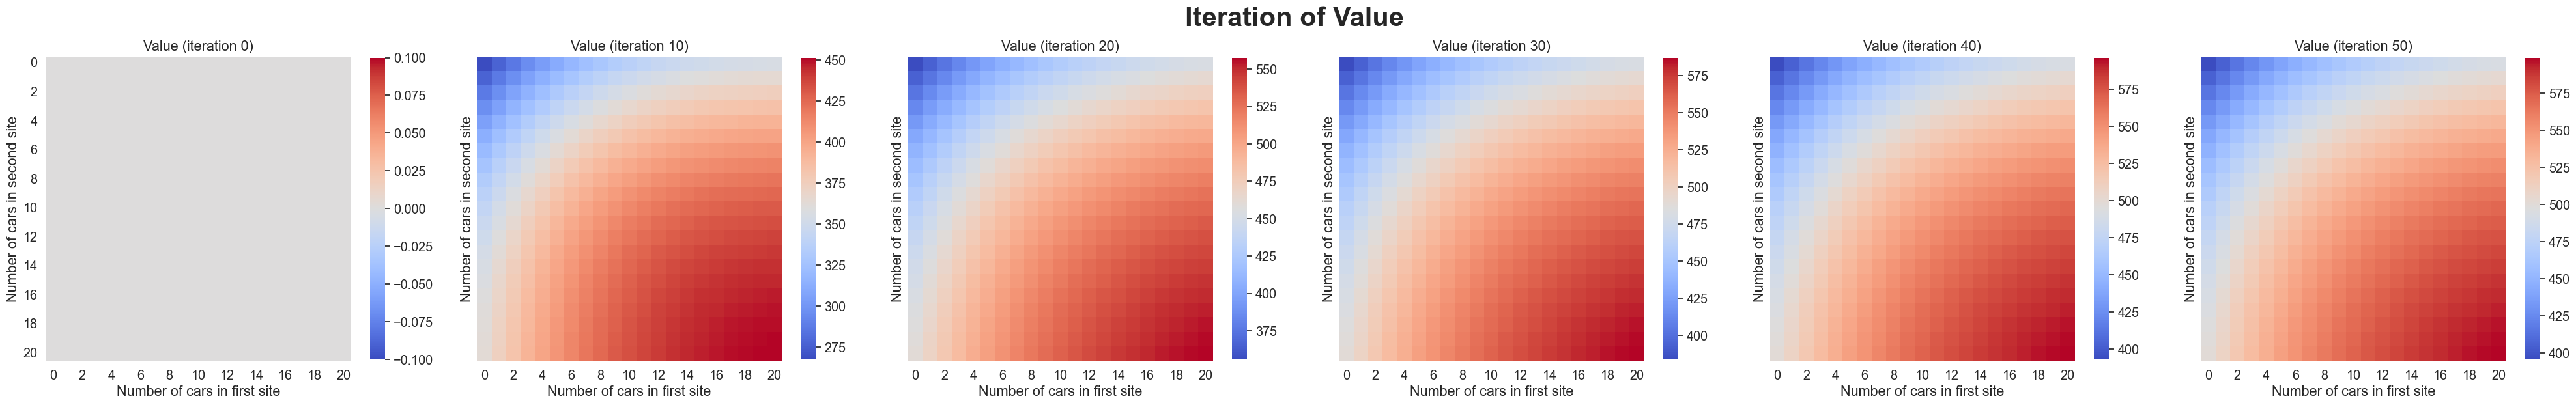

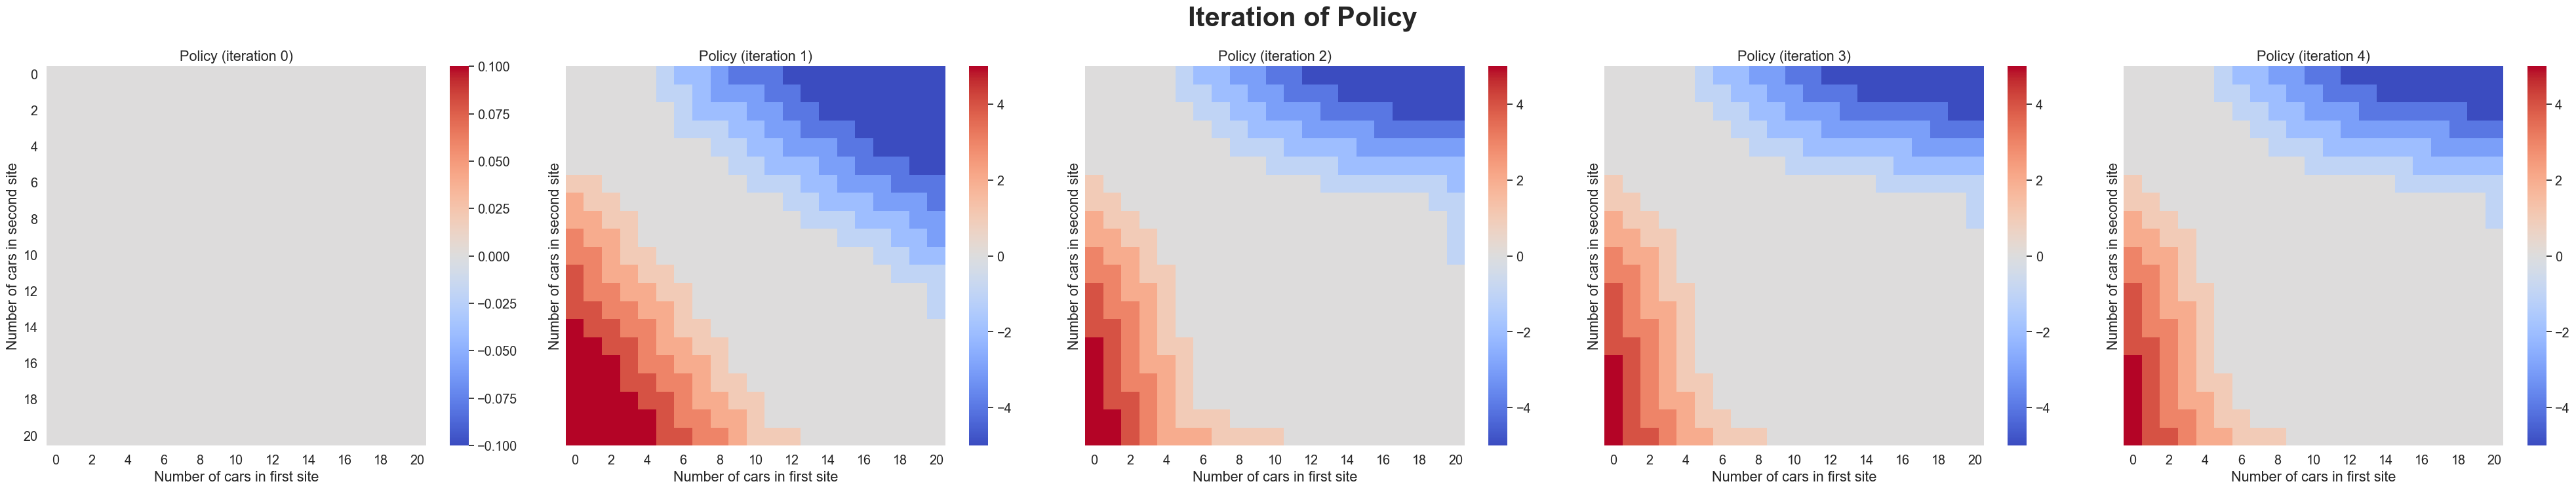

In [109]:
# Policy iteration
jack_policy = JackCar()
# Return probability is simplified as λ of Poisson distribution (for time consuming)
# Poisson-distributed result is listed below
jack_policy.const_return = True 
# Generating rental and return probability matrices
jack_policy.GenProb()
# Iteration
print('Policy iteration starts:')
jack_policy.PolicyIteration()
# Plot
idx_value = np.arange(0, 60)[::10]
PlotIter(jack_policy.value_iter, idx_value, title='Value', figsize=(40,10))
idx_policy = np.arange(0, 5)
PlotIter(jack_policy.policy_iter, idx_policy, title='Policy', figsize=(40,10), y=0.85, shrink=0.65) 

Value iteration with Poisson-distributed return probability
Value iteration starts:
Iteration: 1, δ of value: 26324.199512309555
Iteration: 10, δ of value: 10677.964553158265
Iteration: 20, δ of value: 3354.7942280850257
Iteration: 30, δ of value: 1054.0116070287186
Iteration: 40, δ of value: 331.1501071068924
Iteration: 50, δ of value: 104.04097327357158
Iteration: 60, δ of value: 32.68766606866848
Iteration: 70, δ of value: 10.269833887577988
Iteration: 80, δ of value: 3.226583625015337
Iteration: 90, δ of value: 1.013730310020037
Iteration: 100, δ of value: 0.31849450088338926


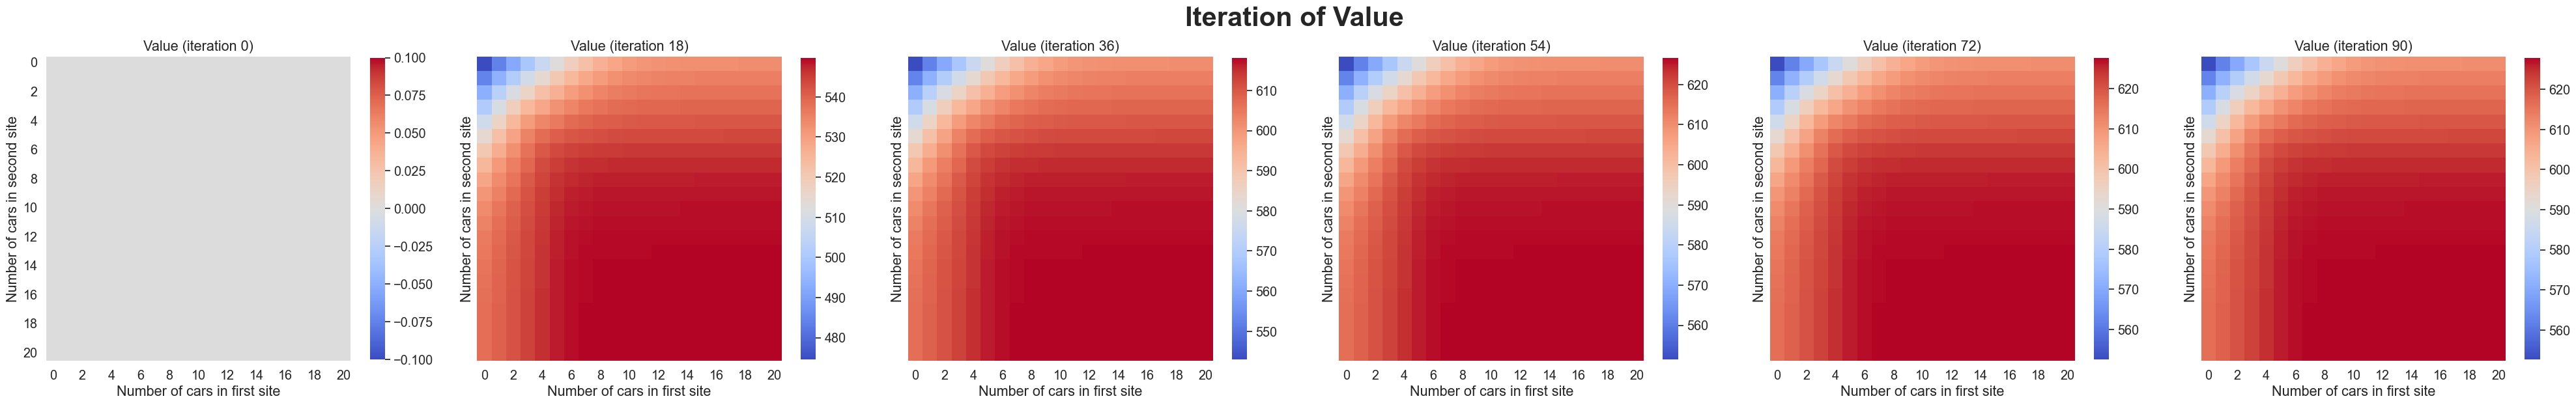

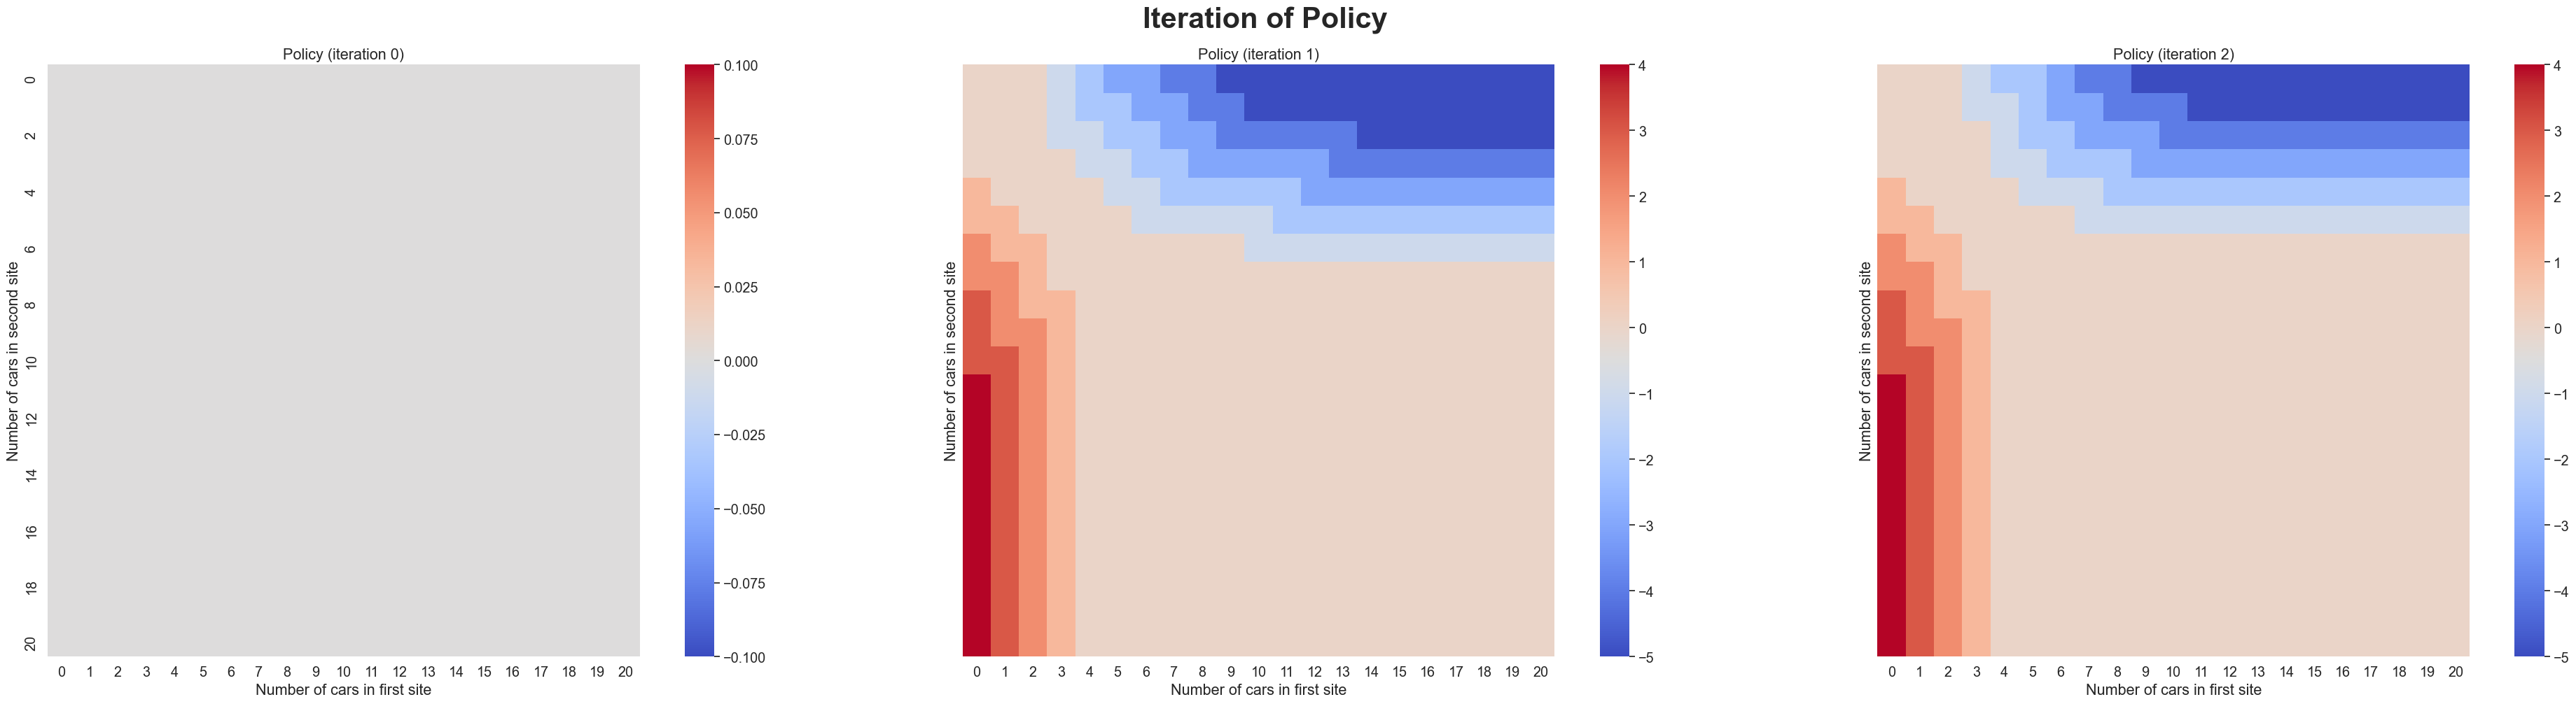

In [122]:
## Value iteration with Poisson-distributed return probability
jack_value = JackCar()
# Generating rental and return probability matrices
jack_value.GenProb()
jack_value.const_return = False
# Iteration
print('Value iteration with Poisson-distributed return probability')
print('Value iteration starts:')
jack_value.ValueIteration()
# Plot
idx_value = np.arange(0, 100)[::18]
PlotIter(jack_value.value_iter, idx_value, title='Value', figsize=(40,10))
idx_policy = np.arange(0, 3)
PlotIter(jack_value.policy_iter, idx_policy, title='Policy', figsize=(40,10), y=0.99, shrink=1)

Policy iteration with Poisson-distributed return probability
Policy iteration starts:
Iteration: 1, δ of value: 25910.01584933322
Iteration: 10, δ of value: 9506.212074871437
Iteration: 20, δ of value: 2986.6979146492376
Iteration: 30, δ of value: 938.3628495769808
Iteration: 40, δ of value: 294.8154992509517
Iteration: 50, δ of value: 92.6253406535252
Iteration: 60, δ of value: 29.101094593061134
Iteration: 70, δ of value: 9.143002341792453
Iteration: 80, δ of value: 2.872554898262024
Iteration: 90, δ of value: 0.902501315693371
Iteration: 100, δ of value: 0.2835484973038547
Iteration: 110, δ of value: 3.430338741512969
Iteration: 120, δ of value: 1.073316854191944
Iteration: 130, δ of value: 0.33721540606347844
Iteration: 140, δ of value: 0.4938014281215146


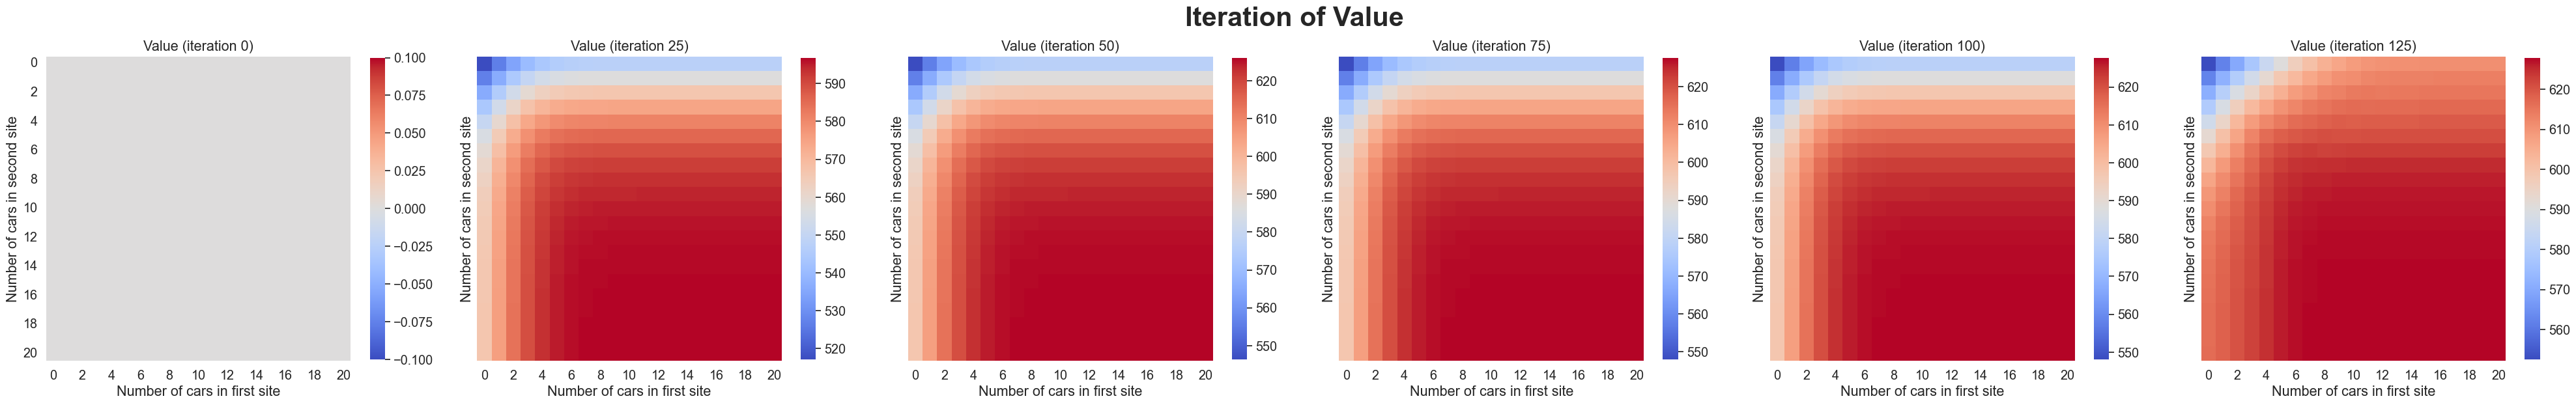

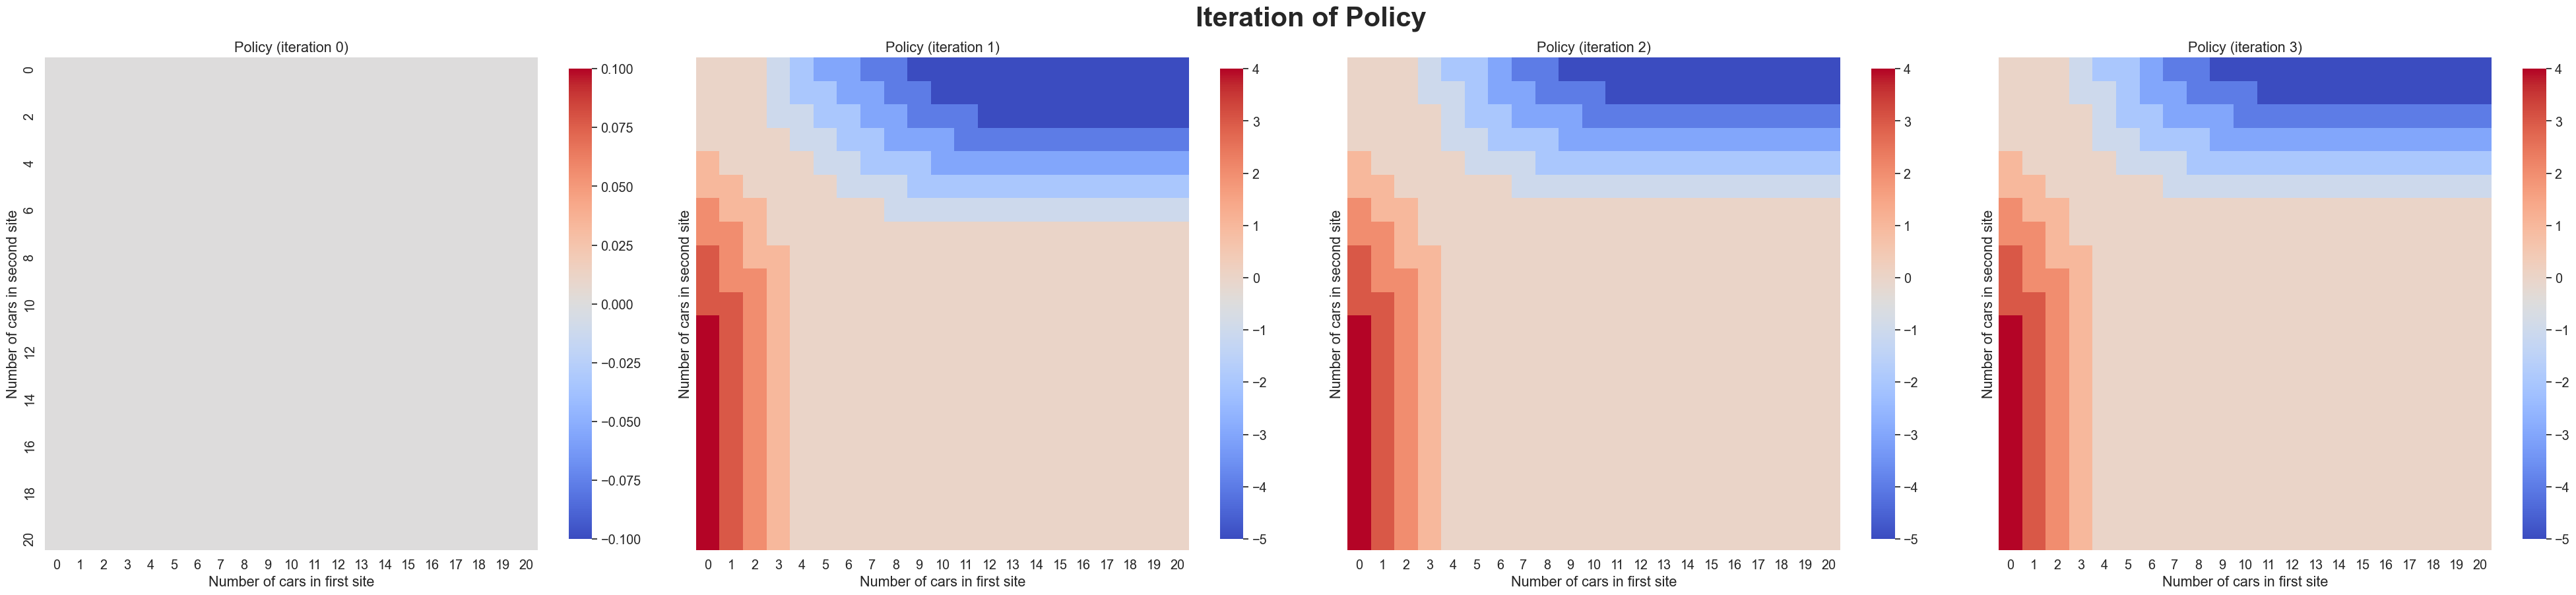

In [115]:
# Policy iteration with Poisson-distributed return probability
jack_policy = JackCar()
jack_policy.const_return = False
# Generating rental and return probability matrices
jack_policy.GenProb()
# Iteration
print('Policy iteration with Poisson-distributed return probability')
print('Policy iteration starts:')
jack_policy.PolicyIteration()
# Plot
idx_value = np.arange(0, 140)[::25]
PlotIter(jack_policy.value_iter, idx_value, title='Value', figsize=(40,10))
idx_policy = np.arange(0, 4)
PlotIter(jack_policy.policy_iter, idx_policy, title='Policy', figsize=(40,10), y=0.92, shrink=0.8) 